# TCP Congestion Control and Bufferbloat


In this assignment, you will create your own network simulation to investigate the dynamics of TCP and how seemingly minor configuration decisions made by network operators can have major performance effects. 

As discussed in lecture, TCP is a protocol for obtaining reliable transmission over an unreliable packet-switched network. Another important component of TCP is congestion control, i.e. limiting end host send rates to prevent network infrastructure from getting overwhelmed with traffic. 

However, networks can suffer congestion-related performance issues even when end hosts use TCP. One such issue, known as bufferbloat, can occur when packet buffers on routers and switches are too large. 

In this assignment, you will use Mininet, a useful tool for network experiments, to emulate a small network and collect various performance statistics relevant to TCP congestion control and bufferbloat. This will allow you to reason about the effects of TCP and router configuration on network performance.   

**Put your name and netID in the cell below:**


**Name:** Monique Legaspi

**NetId:** mlegaspi

## Background

#### TCP Congestion Window Size
The TCP congestion window size parameter, typically styled "cwnd," is maintained by the sender and determines how much traffic can be outstanding (sent but not acknowledged) at any time. There are many algorithms for controlling the value of cwnd during a TCP connection, all with the goal of maximizing the connection's throughput while preventing congestion. The additive increase and multiplicative decrease algorithm was discussed in lecture.

#### Bufferbloat
Bufferbloat is a phenomenon that happens when a switching device is configured to use excessively large buffers, which can in turn cause high latency and packet delay variation (jitter). This can happen even in a typical home network like the following:
<img width=600 src="figures/home-network.png">
Here, the end host in the home network is connected to the home router. The home router is then connected, via cable or DSL, to a headend router run by the Internet service provider (ISP). By simulating and experimenting with a similar network in Mininet, you will see how bufferbloat causes poor performance.

#### Mininet
Mininet is a network emulator with which you can create a custom network of virtual hosts, switches, controllers, and links, all on a single computer. The virtual devices in the emulated network can run real programs; anything that can run on linux can run on a Mininet device too. This makes Mininet a valuable tool for fast and easy simulation of network protcols and measurements. This [Introduction to Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet) is a useful guide for getting started with Mininet's Python API.  The [Mininet website](http://www.mininet.org) has additional resources if you are interested.

## Part A: Network Simulation & Measurement
To start, you should first create the following network using Mininet's Python API, which emulates a typical home netowrk:
<img width=450 src="figures/mininet-topo.png">
Here h1 is a web server that has a fast connection (1Gb/s) to your home router. The home router has a slow downlink connection (1.5Mb/s) to your home computer. The round-trip propagation delay, or the minimum RTT between h1 and h2 is 20ms.  The router buffer (queue) size will be the parameterized independent variable in your simulation.

To create a custom topology in Mininet, we extend the mininet.topo.Topo class. We have already added the switch (the router) to topology for you. You need to add h1, h2, and links with appropriate characteristics to create the setting specified in the image above.  The first few subsections of the [Working with Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet#working) section of the Mininet guide describe how to add elements to a topology and set performance parameters. 

In [98]:
from mininet.topo import Topo

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()
        
        # Create switch s0 (the router)
        switch = self.addSwitch('s0') # added 'switch = ' for use in link1 and link2
        
        # TODO: Create two hosts with names 'h1' and 'h2'
        host1 = self.addHost('h1')
        host2 = self.addHost('h2')
        
        # TODO: Add links with appropriate bandwidth, delay, and queue size parameters. 
        #       Set the router queue size using the queue_size argument
        #       Set bandwidths/latencies using the bandwidths and minimum RTT given in the network diagram above
        link1 = self.addLink(host1, switch, bw=1000, delay='10ms', max_queue_size=queue_size)
        link2 = self.addLink(switch, host2, bw=1.5, delay='10ms', max_queue_size=queue_size)
        
        return

Next, we need a couple of helper functions to generate traffic between the two hosts. The following function starts a long-lived TCP flow which sends data from h1 to h2 using **iperf**. [Iperf](https://iperf.fr/) is "a tool for active measurements of the maximum achievable bandwidth on IP networks."  You can think of this iperf traffic like a one-way video call. It continually attempts to send a high volume of traffic from the web server h1 to the home computer h2. 

The following function receives one argument called `net`, which is an instance of mininet with a BBTopo topology that we have created above. We have written the part for the iperf server (h2). Notice that in iperf, server is the one that receives data, which should be the home computer h2. You need to complete the function to also start iperf on the iperf client (h1). The iperf session should run for the number of seconds given in the `experiment_time` argument.

You will need to use the `popen` function to run shell commands on a mininet host. The first argument to `popen` is a string command just like you would run in your shell. The second argument should be `shell=True`. You will need to look up the appropriate command line options to run iperf as a client for a given amount of time in the documentation here: [https://iperf.fr/iperf-doc.php#3doc](https://iperf.fr/iperf-doc.php#3doc). You will also need to include the IP address of h2 in your iperf command. This IP address can be accessed with the `h2.IP()` method.  

In [99]:
def start_iperf(net, experiment_time):
    # Start a TCP server on host 'h2' using perf. 
    # The -s parameter specifies server mode
    # The -w 16m parameter ensures that the TCP flow is not receiver window limited (not necessary for client)
    print "Starting iperf server"
    h2 = net.get('h2')
    server = h2.popen("iperf -s -w 16m", shell=True)
    
    # TODO: Start an TCP client on host 'h1' using iperf. 
    #       Ensure that the client runs for experiment_time seconds
    print "Starting iperf client"
    h1 = net.get('h1')
    argStr = "iperf -c " + str(h2.IP()) + " -t " + str(experiment_time)
    client = h1.popen(argStr, shell=True)


Next, you need to complete the following function that starts a back-to-back ping train from h1 to h2 to measure RTTs. A ping should be sent every 0.1 seconds. Results should be redirected from stdout to the `outfile` argument.

As before, `net` is an instance of mininet with a BBTopo topology. As before, you will need to use `popen`.  The command argument to `popen` can redirect stdout using `>` just like a normal shell command.  Read the man page for `ping` for details on available command line arguments. Make sure the second argument to `popen` is `shell=True`.

In [114]:
def start_ping(net, outfile="pings.txt"):
    # TODO: Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile
    print "Starting ping train"
    h2 = net.get('h2')
    argStr = "ping -i 0.1 " + str(h2.IP()) + " > " + outfile
    h1 = net.get('h1')
    h1.popen(argStr, shell=True)


Next, we develop some helper functions to measure the congestion window of the TCP traffic. This will let us analyze at the dynamics of the TCP connections in the mininet network. The following functions are already complete.

In [115]:
from subprocess import Popen
import os

def start_tcpprobe(outfile="cwnd.txt"):
    Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)

def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()

We then create a helper function that monitors the queue length on a given interface. This will let us analyze how the number of packets in router buffer queues affects performance. This function is already complete.

In [116]:
from multiprocessing import Process
from monitor import monitor_qlen

def start_qmon(iface, interval_sec=0.1, outfile="q.txt"):
    monitor = Process(target=monitor_qlen,
                      args=(iface, interval_sec, outfile))
    monitor.start()
    return monitor

We also need a helper function that starts a webserver on h1. This function is already complete.

In [117]:
from time import sleep

def start_webserver(net):
    h1 = net.get('h1')
    proc = h1.popen("python http/webserver.py", shell=True)
    sleep(1)
    return [proc]

Finally, we need a helper function that runs on h2, fetches the website from h1 every 3 seconds for `experiment_time`, and prints the average and standard deviation of the download times. This function is already complete

In [118]:
from time import time
from numpy import mean, std
from time import sleep

def fetch_webserver(net, experiment_time):
    h2 = net.get('h2')
    h1 = net.get('h1')
    download_times = []
    
    start_time = time()
    while True:
        sleep(3)
        now = time()
        if now - start_time > experiment_time:
            break
        fetch = h2.popen("curl -o /dev/null -s -w %{time_total} ", h1.IP(), shell=True)
        download_time, _ = fetch.communicate()
        print "Download time: {0}, {1:.1f}s left...".format(download_time, experiment_time - (now-start_time))
        download_times.append(float(download_time))
        
    average_time = mean(download_times)
    std_time = std(download_times)
    print "\nDownload Times: {}s average, {}s stddev\n".format(average_time, std_time)

Now, we need to put together all the pieces to create the network, start all the traffic, and make the measurements. 

The following `bufferbloat()` function should:
* create a `BBTopo` object
* start the TCP and queue monitors
* start a long-lived TCP flow using iperf
* start the ping train
* start the webserver
* Periodically download the index.html web page from h1 and measure how long it takes to fetch it 

Note that the long lived flow, ping train, and webserver downloads should all be happening simultaneously. Once you have completed the assignment steps up until here, complete the sections marked `TODO` in the below `bufferbloat()` function. Each TODO section requires adding one line to call a function defined above.

In [119]:
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

from time import time
import os
from subprocess import call

def bufferbloat(queue_size, experiment_time, experiment_name):
    # Don't forget to use the arguments!
    
    # Set the cwnd control algorithm to "reno" (half cwnd on 3 duplicate acks)
    #    Modern Linux uses CUBIC-TCP by default that doesn't have the usual sawtooth
    #    behaviour.  For those who are curious, replace reno with cubic
    #    see what happens...
    os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")
    
    # create the topology and network
    topo = BBTopo(queue_size)
    net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink, 
                  controller= OVSController)
    net.start()

    # Print the network topology 
    dumpNodeConnections(net.hosts)
    
    # Performs a basic all pairs ping test to ensure the network set up properly
    net.pingAll()
    
    # Start monitoring TCP cwnd size
    outfile = "{}_cwnd.txt".format(experiment_name)
    start_tcpprobe(outfile)

    # TODO: Start monitoring the queue sizes with the start_qmon() function.
    #       Fill in the iface argument with "s0-eth2" if the link from s0 to h2
    #       is added second in BBTopo or "s0-eth1" if the link from s0 to h2
    #       is added first in BBTopo. This is because we want to measure the 
    #       number of packets in the outgoing queue from s0 to h2. 
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface="s0-eth2", outfile=outfile)

    # TODO: Start the long lived TCP connections with the start_iperf() function
    iperf = start_iperf(net, experiment_time)
    
    # TODO: Start pings with the start_ping() function
    outfile = "{}_pings.txt".format(experiment_name)
    ping = start_ping(net, outfile=outfile)
    
    # TODO: Start the webserver with the start_webserver() function
    webserver = start_webserver(net)
    
    # TODO: Measure and print website download times with the fetch_webserver() function
    fetch = fetch_webserver(net, experiment_time)
    
    # Stop probing 
    stop_tcpprobe()
    qmon.terminate()
    net.stop()
    
    # Ensure that all processes you create within Mininet are killed.
    Popen("pgrep -f webserver.py | xargs kill -9", shell=True).wait()
    call(["mn", "-c"])

Once you have completed all the steps above, use the `bufferbloat()` function to run the experiment twice, once with queue size of a 20 packets and then queue size of 100 packets. Make sure to run the experiments long enough to see the dynamics of TCP, like the sawtooth behavior of cwnd, in your results (300 seconds should be good).  Choose `experiment_name` arguments that reflect the queue size

In [120]:
from subprocess import call
call(["mn", "-c"])

# TODO: call the bufferbloat function twice, once with queue size of 20 packets and once with a queue size of 100.
bufferbloat(20, 300, "queue20")
bufferbloat(100, 300, "queue100")


h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting iperf server
Starting iperf client
Starting ping train
Download time: 0.498, 297.0s left...
Download time: 0.434, 293.5s left...
Download time: 1.449, 290.0s left...
Download time: 1.257, 285.6s left...
Download time: 1.645, 281.3s left...
Download time: 1.733, 276.6s left...
Download time: 1.717, 271.9s left...
Download time: 1.239, 267.1s left...
Download time: 1.271, 262.9s left...
Download time: 1.811, 258.6s left...
Download time: 1.233, 253.8s left...
Download time: 0.497, 249.5s left...
Download time: 0.447, 246.0s left...
Download time: 1.415, 242.5s left...
Download time: 0.502, 238.1s left...
Download time: 0.448, 234.6s left...
Download time: 1.385, 231.1s left...
Download time: 0.504, 226.7s left...
Download time: 0.448, 223.2s left...
Download time: 1.479, 219.7s left...
Download time: 0.504, 215.2s left...
Download time: 0.441, 211.7s left...
Download time: 0.447, 208.2s left...
Download time: 1.419, 204.7s left...
Download time: 0.502, 200.3s left...
Download ti

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting iperf server
Starting iperf client
Starting ping train
Download time: 1.608, 297.0s left...
Download time: 1.505, 292.4s left...
Download time: 1.537, 287.9s left...
Download time: 1.606, 283.3s left...
Download time: 1.637, 278.7s left...
Download time: 1.698, 274.0s left...
Download time: 1.735, 269.3s left...
Download time: 1.795, 264.6s left...
Download time: 1.843, 259.7s left...
Download time: 1.866, 254.9s left...
Download time: 1.925, 250.0s left...
Download time: 1.974, 245.1s left...
Download time: 2.006, 240.1s left...
Download time: 2.024, 235.0s left...
Download time: 5.108, 230.0s left...
Download time: 2.141, 221.9s left...
Download time: 5.369, 216.7s left...
Download time: 5.543, 208.3s left...
Download time: 2.320, 199.8s left...
Download time: 2.353, 194.4s left...
Download time: 2.383, 189.0s left...
Download time: 2.414, 183.6s left...
Download time: 2.447, 178.2s left...
Download time: 6.149, 172.7s left...
Download time: 2.547, 163.6s left...
Download ti

## Part B: Plotting Results

In this part of the assignment, you will analyze your measurements by plotting the variations in congestion window, queue length, and ping RTT versus time. We have provided plotting functions for each of these measurements, which are called in the following already complete `plot_measurements()` function. 


In [121]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
from plot_qsize import plot_queue_length
from plot_ping import plot_ping_rtt

def plot_measurements(experiment_name_list, cwnd_histogram=False):
    
    # plot the congestion window over time
    for name in experiment_name_list:
        cwnd_file = "{}_cwnd.txt".format(name)
        plot_congestion_window(cwnd_file, histogram=cwnd_histogram)
    
    # plot the queue size over time
    for name in experiment_name_list:
        qsize_file = "{}_qsize.txt".format(name)
        plot_queue_length(qsize_file)
    
    # plot the ping RTT over time
    for name in experiment_name_list:
        ping_file = "{}_pings.txt".format(name)
        plot_ping_rtt(ping_file)

Now you need to call the `plot_measurements` function such that the `experiment_name_list` argument is list of the `experiment_name` arguments you used to run `bufferbloat()` above.  This should generate 6 plots with the results of the experiments.

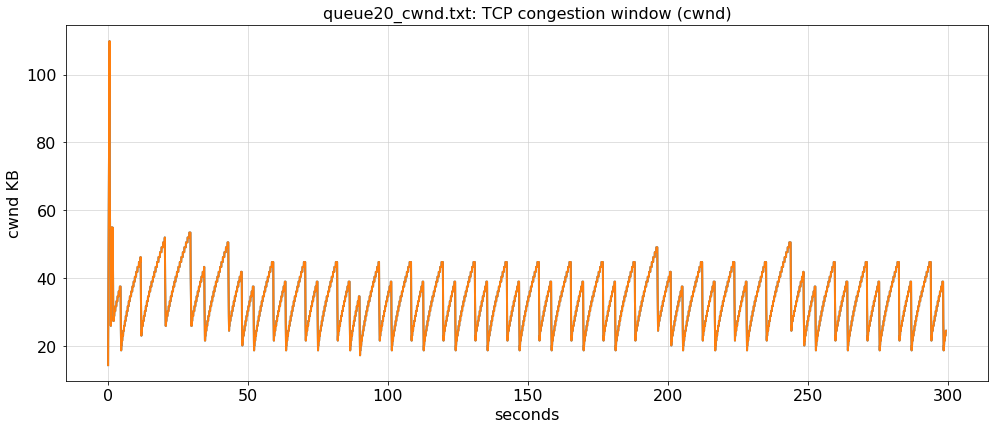

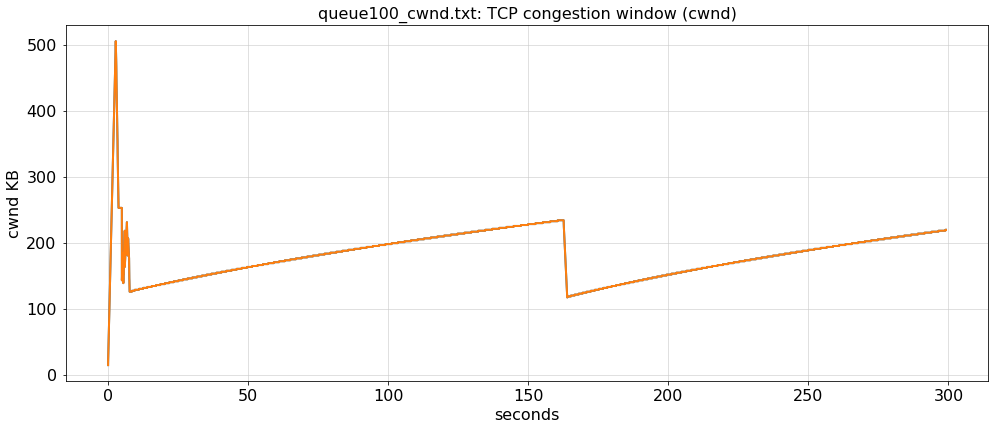

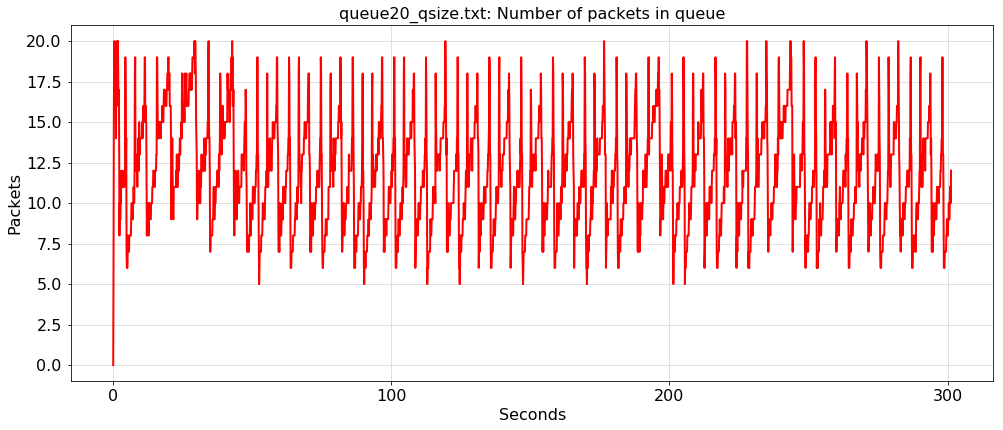

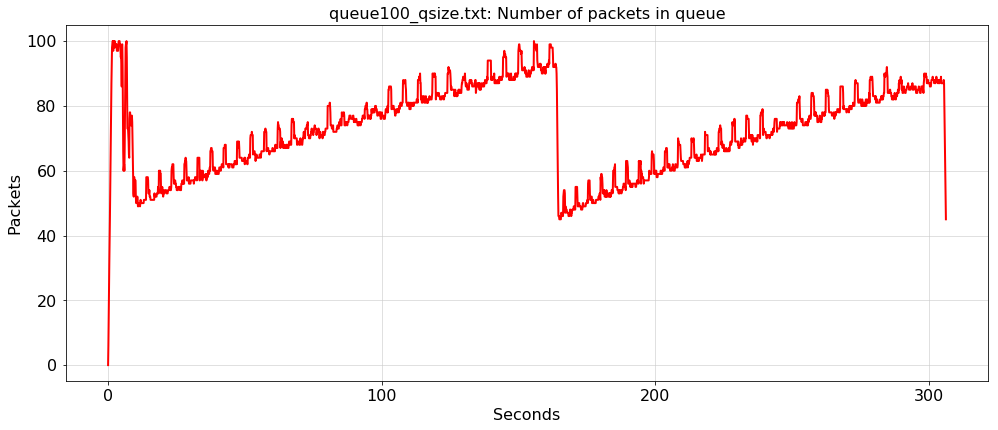

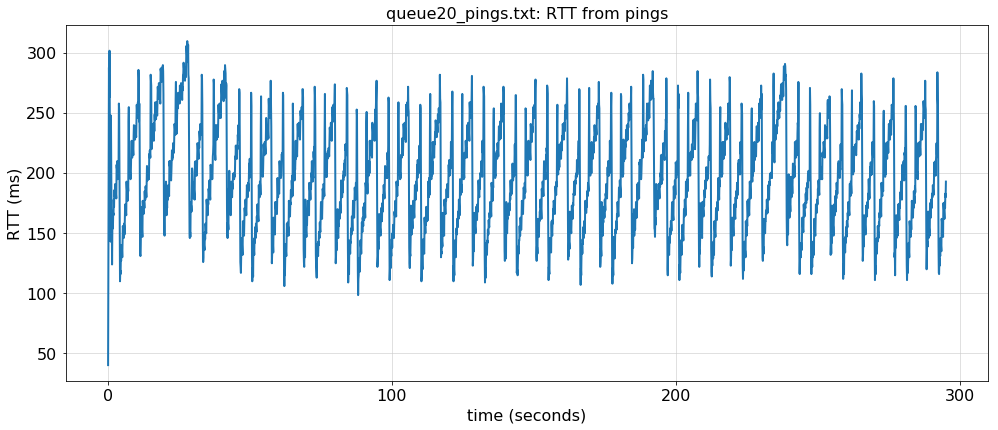

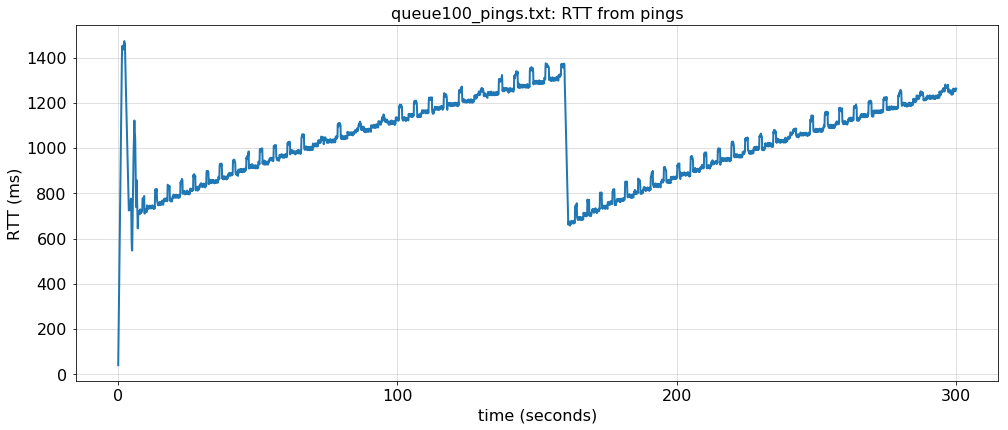

In [122]:
#TODO: Call plot_measurements() to plot your results
plot_measurements(["queue20", "queue100"])

## Part C: Analysis

In this part of the assignment, you will answer some questions about TCP and bufferbloat using your simulations and the plots from the previous section.  This questions are intentionally open-ended and many have multiple correct answers.  There is no required answer length, but attempt to be both thorough and concise.  1-2 sentences is probably too short. More than 2-3 paragraphs is probably too long. 

Take some time first to think about the simulation you just performed. The simulation was set up like a home network with a home computer connected to a remote server through a router. The link from the router to the server had much lower bandwidth than the link from the home computer to the router. The independent variable in the simulation was the maximum length of the buffer of packets waiting to be sent from the router to the server. 

There were 3 sources of traffic:
1. A long-lasting TCP session (creating using iperf) sending a high volume of traffic from the home computer to the server.
2. Regularly spaced pings and ping replies to and from the home computer and the server
3. Regularly spaced attempts to download a website (using HTTP over TCP) from the home computer to the server.

As you (hopefully) discovered through the experiment, increasing the length of the packet buffer on the router significantly reduced performance by both ping RTT and HTTP download rate metrics. 

### Questions

#### Q1.
What computer networks other than a home network might have a configuration like the one you simulated?

#### A1.
An example of a computer network that might have the same configuration as our simulation is a modern smartphone that tries to connect to the Internet or cell-service in a weak area. Your smartphone will be fast, but the network willbe slow. If you're trying to access/download something continuously for a long period of time, like a video essay on YouTube, while on this weeak connection, it's going to buffer a lot, as we've just experienced, because the network won't be able to handle such continuous and voluminous traffic, even though the smartphone can.

#### Q2.
Write a symbolic equation to describe the relation between RTT and queue size. 

The symbolic equation should be generalized to any queue size. Basically, consider a snapshot of a system at one point of time, and use queue size and link delays parametrically to compute the RTT

An example (incorrect) symbolic equation: 
$$RTT = kq^2$$
where $k$ is a constant factor and $q$ is the number of packets in the queue. Your equation is not limited to $k$ and $q$. 

#### A2.
I apologize, but I couldn't find a good general formula that describes the relation between RTT and queue size. Here is some data I collected (all numbers are approximate):

for max_queue_size of 100:
- t: 17s
    - RTT: 800ms
    - queue: 60 packets
    - link delay: 1.606s
- t: 160s
    - RTT: 1400ms
    - queue: 100 packets
    - link delay: 2.703s
- t: 280s
    - RTT: 1260ms
    - queue: 90 packets
    - link delay: 2.416s

for max_queue_size of 20:
- t: 30s
    - RTT: 310ms
    - queue: 19 packets
    - link delay: 1.717s
- t: 150s
    - RTT: 120ms
    - queue: 5 packets
    - link delay: 1.415s
- t: 290s
    - RTT: 275ms
    - queue: 18 packets
    - link delay: 0.449s

Without considering link delay, I found there to be a correlation in the ratio RTT : packets in queue, which was consistently around 14 for max_queue_size of 100, around 15-16 for max_queue_size of 20. Thus, my simple (but definitely incorrect) equation is as follows:

$$RTT = 14q$$

#### Q3.  
Describe in technical terms why increasing buffer size reduces performance (RTTs and webpage download times), causing the bufferbloat effect.  Be sure to explicitly reference the plots you generated and the relationship between TCP congestion control and buffer size. *This is the most important question and will be weighted correspondingly more.*

#### A3.
Increasing buffer size reduces performance because it results in a greater number of to-be-serviced packets needing to be managed by the FIFO queue manager, which is highly inefficient with the bottleneck of the slow network on the server side of the router. Due to this bottleneck, there will always be a slow release from the queue, no matter how quickly things enter it--in fact, it will be even more of a disaster if the client side is fast, because the queue will fill up and packets will end up being dropped. We can notice in the graphs above that, with a queue size of 20, the RTTs of the pings stay generally consistent; however, with a queue size of 100, the RTT steadily rises with the number of packets stuck in the queue. The cwnd also becomes larger as the number of packets in the queue increases; with a large buffer size, it becomes more difficult to ascertain when the packets are being sent too fast, because it takes longer for us to hit the max queue size (which generally alerts us when to reduce the cwnd). Contrast the queue100_cwnd.txt graph (slow to self-adjust) with queue20_cwnd.txt, which is constantly adjusting itself to match the needs of the network.

#### Q4. 
Re-describe the cause of the bufferbloat effect using a non-technical analogy to something other than computer networking.  It is important to be able to describe technical content such that a layperson can understand, and generating analogies often helps your own reasoning. 

#### A4.
Bufferbloat can be compared to a line of students awaiting lunch at a dining hall--let's say Wucox. The students are like packets, and the line they're standing in is the link. The "bandwidth" could probably be the size limit on whatever things the students are carrying with them--backpacks, athletic equipment, large science projects, etc.--and the "link delay" could be how long it takes the student to get from the main entrance of the dhall (the back of the line) to the dining area (the front of the line), where they can sit down and eat.

There is a very long line of students, and they're all very hungry, so they want to get from the main entrance to the dining area as quickly as possible (aka, we want to reduce link delay as much as we can). But if there's too many students in the line, there's the danger of overcrowding, and some students may be accidentally hurt or pushed out (like a lost packet). One thing we could do to prevent this is have some students wait outside of the dhall, and station a staff member outside that lets people in as the line gets thinner/shorter. This collection of outside students would be the queue, and the staff member would be how we manage it (FIFO); they let in the first student who came when the line has room, and if too many people try to enter the outside group (exceeding queue size), the staff member may have to turn them away, because they can't manage that many students.

Where bufferbloat becomes an issue is when this outside group gets very, very large, and there are more students coming in than going out. As we witnessed in this simulation, it can be difficult to speedily manage a queue with a large max size; the staff member will not be able to keep control of the queue, leading students to push through and try to enter the line via different routes, which might fail because the line is still experiencing traffic. These student-packets are then even further delayed in their quest to get lunch than if they had just waited in a really long line to begin with. And as the queue (group of outside students) gets bigger, this problem will only get worse, because the staff member will have even more trouble wrangling all the students.

#### Q5. 
Is the bufferbloat effect specific to the type of network, traffic, and/or TCP congestion control algorithm we simulated, or is it a general phenomenon?

Are there any times when increasing router buffer size would improve performance? If so, give an example.  If not, explain why not. 

#### A5.
Bufferbloat seems to be a general phenomenon; it could happen with any kind of network that uses a single/inefficient queueing system, because any network can be overwhelmed by a large and uncontrollable influx of packets. Increasing router buffer size would not improve performance, even if you implement a smarter queueing system (as in Q6) because it will always result in having more to-be-serviced packets to manage, which becomes a greater hassle and harder to keep in check with a greater quantity.

#### Q6.
Identify and describe a way to mitigate the bufferbloat problem without reducing buffer sizes.  

#### A6.
One way to mitigate the bufferbloat problem without reducing buffer size would be to use a different method than FIFO to manage the queue. We could use multiple queues and implement weighted fair queueing, so as to prioritize the delivery of more important packets without starving out smaller packets from being delivered in a timely manner. The method we discussed in precept, wherein we service packets based on "finishing time", could come in handy here, as it allows packets to be sent in a quasi-chronological order that neither bloats the network nor endangers the smaller packets with extreme delays.

## Submission 

**Remember to "Save and Checkpoint" (from the "File" menu above) before you leave the notebook or close your tab.**
